## Importing libraries

In [103]:
import networkx as nx
import pandas as pd
import networkx.algorithms.community as nx_comm
import community as community_louvain
import matplotlib.cm as cm
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import powerlaw

#### the list of all airlines (open source dataset)

In [104]:
airports_ext = pd.read_csv('https://raw.githubusercontent.com/VladislavsLuksha/European_Air_Transportation_Network/main/DATA/Flights%20Data/OpenFlights/airports.csv')
airports_ext = airports_ext.iloc[:,:9]
airports_ext.head()

,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146


#### the list of all airports (open source dataset)

In [105]:
from FlightRadar24.api import FlightRadar24API
fr_api = FlightRadar24API()


In [106]:
airports = fr_api.get_airports()

In [107]:
airports = pd.DataFrame(airports)
airports.head()

,name,iata,icao,lat,lon,country,alt
0,A Coruna Airport,LCG,LECO,43.302059,-8.377250,Spain,326
1,Aachen Merzbruck Airport,AAH,EDKA,50.823051,6.186111,Germany,623
2,Aalborg Airport,AAL,EKYT,57.092781,9.849164,Denmark,10
3,Aarhus Airport,AAR,EKAH,56.300011,10.619000,Denmark,82
4,Aarhus Sea Airport,QEA,EKAC,56.151993,10.247725,Denmark,1


In [108]:
airports = airports.dropna()

In [109]:
airports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5042 entries, 0 to 5041
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   name     5042 non-null   object 
 1   iata     5042 non-null   object 
 2   icao     5042 non-null   object 
 3   lat      5042 non-null   float64
 4   lon      5042 non-null   float64
 5   country  5042 non-null   object 
 6   alt      5042 non-null   object 
dtypes: float64(2), object(5)
memory usage: 275.9+ KB


#### ASIA AND AUSTRALIA

In [110]:
# Define the latitude and longitude ranges for Asia and Australia
lat_min = -55
lat_max = 95
long_min = 47.16
long_max = 180


# Filter the DataFrame to only include locations within the boundaries
airports_asia = airports[(airports['lat'] >= lat_min) & (airports['lat'] <= lat_max) &
        (airports['lon'] >= long_min) & (airports['lon'] <= long_max)]

In [111]:
# List of countries to remove
countries_to_remove = ['Madagascar', 'Somalia']

# Create a Boolean mask that identifies the rows to be removed
mask = airports_asia['country'].isin(countries_to_remove)

# Drop the rows identified by the Boolean mask
airports_asia = airports_asia[~mask]


In [112]:
import folium

# Define the center point for the map
center_lat = (lat_min + lat_max) / 2
center_long = (long_min + long_max) / 2

# Create a map centered on the defined center point
m = folium.Map(location=[center_lat, center_long], zoom_start=3)

# Add a rectangle to the map to represent the boundaries
folium.Rectangle(
    bounds = [[lat_min, long_min], [lat_max, long_max]],
    color='purple',
    fill= False
).add_to(m)

# Add markers for each airport in the DataFrame
for index, row in airports_asia.iterrows():
   if lat_min <= row['lat'] <= lat_max and long_min <= row['lon'] <= long_max:
        radius = 2  # Change the radius to adjust the size of the dots
        color = 'purple'  # Change the color of the dots
        fill_color = 'purple'  # Change the fill color of the dots
        fill_opacity = 0.2  # Change the fill opacity of the dots
        folium.CircleMarker(
            location=[row['lat'], row['lon']],
            radius=radius,
            color=color,
            fill_color=fill_color,
            fill_opacity=fill_opacity,
            tooltip=row['name']
        ).add_to(m)

# Show the map
m

In [113]:
airports_asia.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1448 entries, 6 to 5041
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   name     1448 non-null   object 
 1   iata     1448 non-null   object 
 2   icao     1448 non-null   object 
 3   lat      1448 non-null   float64
 4   lon      1448 non-null   float64
 5   country  1448 non-null   object 
 6   alt      1448 non-null   object 
dtypes: float64(2), object(5)
memory usage: 90.5+ KB


# THE CODE FOR OBTAINING SCHEDULES

In [114]:
#getting data for european airports (before war)

In [115]:
import pandas as pd
from tqdm import tqdm
import requests
import json

# Replace [API_KEY] with your own API key
API_KEY = '____'

# Define the start and end dates
start_date = '2023-01-21'
end_date = '2023-01-28'

airport_codes= list(airports_asia['iata'].unique())

# Initialize an empty list to store the API responses
responses = []

# Loop over the list of airport codes
for airport in tqdm(airport_codes, desc='Getting timetable'):
    # Make a GET request to the API
    url = f'https://aviation-edge.com/v2/public/flightsHistory?key={API_KEY}&code={airport}&type=departure&date_from={start_date}&date_to={end_date}'
    response = requests.get(url,timeout=30)
    
    # Add the API response to the list
    try:
        responses.append(response.json())
    except json.JSONDecodeError as e:
        print(f'Error decoding JSON response for {airport}: {e}')

Getting timetable: 100%|████████████████████| 1448/1448 [16:42<00:00,  1.44it/s]


In [116]:
df_list = []
for sublist in responses:
    try:
        df_list.append(pd.DataFrame(sublist))
    except ValueError as e:
        print("Error while converting JSON to dataframe:", e)

df = pd.concat(df_list)

Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, 

In [117]:
#df= df.drop(columns ='codeshared')
df = df.reset_index(drop=True)
df.head()

,type,status,departure,arrival,airline,flight,codeshared
0,departure,active,"{'iataCode': 'abd', 'icaoCode': 'oiaa', 'sched...","{'iataCode': 'thr', 'icaoCode': 'oiii', 'termi...","{'name': 'varesh airlines', 'iataCode': '', 'i...","{'number': '5875', 'iataNumber': '', 'icaoNumb...",NaN
1,departure,active,"{'iataCode': 'abd', 'icaoCode': 'oiaa', 'sched...","{'iataCode': 'thr', 'icaoCode': 'oiii', 'sched...","{'name': 'qeshm airlines', 'iataCode': 'qb', '...","{'number': '1217', 'iataNumber': 'qb1217', 'ic...",NaN
2,departure,unknown,"{'iataCode': 'abd', 'icaoCode': 'oiaa', 'sched...","{'iataCode': 'ifn', 'icaoCode': 'oifm', 'sched...","{'name': 'iran aseman airlines', 'iataCode': '...","{'number': '3758', 'iataNumber': 'ep3758', 'ic...",NaN
3,departure,active,"{'iataCode': 'abd', 'icaoCode': 'oiaa', 'sched...","{'iataCode': 'thr', 'icaoCode': 'oiii', 'termi...","{'name': 'iran aseman airlines', 'iataCode': '...","{'number': '3751', 'iataNumber': 'ep3751', 'ic...",NaN
4,departure,active,"{'iataCode': 'abd', 'icaoCode': 'oiaa', 'sched...","{'iataCode': 'mhd', 'icaoCode': 'oimm', 'sched...","{'name': 'sepehran airlines', 'iataCode': 'is'...","{'number': '4367', 'iataNumber': 'is4367', 'ic...",NaN


In [118]:
df = df.drop(columns = ['type'])

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548679 entries, 0 to 548678
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   status      548679 non-null  object
 1   departure   548679 non-null  object
 2   arrival     548679 non-null  object
 3   airline     548679 non-null  object
 4   flight      548679 non-null  object
 5   codeshared  264724 non-null  object
dtypes: object(6)
memory usage: 25.1+ MB


In [120]:
# Use pandas.json_normalize() to extract the values from the dictionaries
departures = pd.json_normalize(df['departure'])

# Rename the columns to include 'departure' and the dictionary key
departures.columns = ['departure_' + col for col in departures.columns]

# Concatenate the original DataFrame and the new departures DataFrame
ndf = pd.concat([df, departures], axis=1)

# Drop the original 'departure' column
ndf = ndf.drop('departure', axis=1)

# Print the resulting DataFrame
ndf.head()

,status,arrival,airline,flight,codeshared,departure_iataCode,departure_icaoCode,departure_scheduledTime,departure_delay,departure_actualTime,departure_estimatedRunway,departure_actualRunway,departure_terminal,departure_gate,departure_estimatedTime
0,active,"{'iataCode': 'thr', 'icaoCode': 'oiii', 'termi...","{'name': 'varesh airlines', 'iataCode': '', 'i...","{'number': '5875', 'iataNumber': '', 'icaoNumb...",NaN,abd,oiaa,2023-01-21t03:45:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,active,"{'iataCode': 'thr', 'icaoCode': 'oiii', 'sched...","{'name': 'qeshm airlines', 'iataCode': 'qb', '...","{'number': '1217', 'iataNumber': 'qb1217', 'ic...",NaN,abd,oiaa,2023-01-21t18:45:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,unknown,"{'iataCode': 'ifn', 'icaoCode': 'oifm', 'sched...","{'name': 'iran aseman airlines', 'iataCode': '...","{'number': '3758', 'iataNumber': 'ep3758', 'ic...",NaN,abd,oiaa,2023-01-21t19:50:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,active,"{'iataCode': 'thr', 'icaoCode': 'oiii', 'termi...","{'name': 'iran aseman airlines', 'iataCode': '...","{'number': '3751', 'iataNumber': 'ep3751', 'ic...",NaN,abd,oiaa,2023-01-21t22:45:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,active,"{'iataCode': 'mhd', 'icaoCode': 'oimm', 'sched...","{'name': 'sepehran airlines', 'iataCode': 'is'...","{'number': '4367', 'iataNumber': 'is4367', 'ic...",NaN,abd,oiaa,2023-01-21t23:30:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [121]:
ndf = ndf.drop(columns = ['departure_icaoCode','departure_actualTime', 'departure_estimatedRunway' , 'departure_actualRunway', 'departure_terminal' , 'departure_gate', 'departure_estimatedTime'])
ndf.head()

,status,arrival,airline,flight,codeshared,departure_iataCode,departure_scheduledTime,departure_delay
0,active,"{'iataCode': 'thr', 'icaoCode': 'oiii', 'termi...","{'name': 'varesh airlines', 'iataCode': '', 'i...","{'number': '5875', 'iataNumber': '', 'icaoNumb...",NaN,abd,2023-01-21t03:45:00.000,NaN
1,active,"{'iataCode': 'thr', 'icaoCode': 'oiii', 'sched...","{'name': 'qeshm airlines', 'iataCode': 'qb', '...","{'number': '1217', 'iataNumber': 'qb1217', 'ic...",NaN,abd,2023-01-21t18:45:00.000,NaN
2,unknown,"{'iataCode': 'ifn', 'icaoCode': 'oifm', 'sched...","{'name': 'iran aseman airlines', 'iataCode': '...","{'number': '3758', 'iataNumber': 'ep3758', 'ic...",NaN,abd,2023-01-21t19:50:00.000,NaN
3,active,"{'iataCode': 'thr', 'icaoCode': 'oiii', 'termi...","{'name': 'iran aseman airlines', 'iataCode': '...","{'number': '3751', 'iataNumber': 'ep3751', 'ic...",NaN,abd,2023-01-21t22:45:00.000,NaN
4,active,"{'iataCode': 'mhd', 'icaoCode': 'oimm', 'sched...","{'name': 'sepehran airlines', 'iataCode': 'is'...","{'number': '4367', 'iataNumber': 'is4367', 'ic...",NaN,abd,2023-01-21t23:30:00.000,NaN


In [122]:
# Use pandas.json_normalize() to extract the values from the dictionaries
arrivals = pd.json_normalize(ndf['arrival'])

# Rename the columns to include 'arrival' and the dictionary key
arrivals.columns = ['arrival_' + col for col in arrivals.columns]

# Concatenate the original DataFrame and the new departures DataFrame
ndf = pd.concat([ndf, arrivals], axis=1)

# Drop the original 'departure' column
ndf = ndf.drop('arrival', axis=1)

# Print the resulting DataFrame
ndf.head()

,status,airline,flight,codeshared,departure_iataCode,departure_scheduledTime,departure_delay,arrival_iataCode,arrival_icaoCode,arrival_terminal,arrival_scheduledTime,arrival_estimatedTime,arrival_baggage,arrival_delay,arrival_gate,arrival_actualTime,arrival_estimatedRunway,arrival_actualRunway
0,active,"{'name': 'varesh airlines', 'iataCode': '', 'i...","{'number': '5875', 'iataNumber': '', 'icaoNumb...",NaN,abd,2023-01-21t03:45:00.000,NaN,thr,oiii,2,2023-01-21t05:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,active,"{'name': 'qeshm airlines', 'iataCode': 'qb', '...","{'number': '1217', 'iataNumber': 'qb1217', 'ic...",NaN,abd,2023-01-21t18:45:00.000,NaN,thr,oiii,NaN,2023-01-21t20:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,unknown,"{'name': 'iran aseman airlines', 'iataCode': '...","{'number': '3758', 'iataNumber': 'ep3758', 'ic...",NaN,abd,2023-01-21t19:50:00.000,NaN,ifn,oifm,NaN,2023-01-21t20:45:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,active,"{'name': 'iran aseman airlines', 'iataCode': '...","{'number': '3751', 'iataNumber': 'ep3751', 'ic...",NaN,abd,2023-01-21t22:45:00.000,NaN,thr,oiii,4,2023-01-22t00:15:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,active,"{'name': 'sepehran airlines', 'iataCode': 'is'...","{'number': '4367', 'iataNumber': 'is4367', 'ic...",NaN,abd,2023-01-21t23:30:00.000,NaN,mhd,oimm,NaN,2023-01-22t01:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [123]:
ndf = ndf.drop(columns = [ 'arrival_icaoCode' , 'arrival_terminal', 'arrival_baggage' ,'arrival_actualTime', 'arrival_estimatedTime', 'arrival_estimatedRunway','arrival_actualRunway','arrival_gate'])
ndf.head()

,status,airline,flight,codeshared,departure_iataCode,departure_scheduledTime,departure_delay,arrival_iataCode,arrival_scheduledTime,arrival_delay
0,active,"{'name': 'varesh airlines', 'iataCode': '', 'i...","{'number': '5875', 'iataNumber': '', 'icaoNumb...",NaN,abd,2023-01-21t03:45:00.000,NaN,thr,2023-01-21t05:00:00.000,NaN
1,active,"{'name': 'qeshm airlines', 'iataCode': 'qb', '...","{'number': '1217', 'iataNumber': 'qb1217', 'ic...",NaN,abd,2023-01-21t18:45:00.000,NaN,thr,2023-01-21t20:00:00.000,NaN
2,unknown,"{'name': 'iran aseman airlines', 'iataCode': '...","{'number': '3758', 'iataNumber': 'ep3758', 'ic...",NaN,abd,2023-01-21t19:50:00.000,NaN,ifn,2023-01-21t20:45:00.000,NaN
3,active,"{'name': 'iran aseman airlines', 'iataCode': '...","{'number': '3751', 'iataNumber': 'ep3751', 'ic...",NaN,abd,2023-01-21t22:45:00.000,NaN,thr,2023-01-22t00:15:00.000,NaN
4,active,"{'name': 'sepehran airlines', 'iataCode': 'is'...","{'number': '4367', 'iataNumber': 'is4367', 'ic...",NaN,abd,2023-01-21t23:30:00.000,NaN,mhd,2023-01-22t01:00:00.000,NaN


In [124]:
# Use pandas.json_normalize() to extract the values from the dictionaries
airlines = pd.json_normalize(ndf['airline'])

# Rename the columns to include 'airline' and the dictionary key
airlines.columns = ['airline_' + col for col in airlines.columns]

# Concatenate the original DataFrame and the new departures DataFrame
ndf = pd.concat([ndf, airlines], axis=1)

# Drop the original 'departure' column
ndf = ndf.drop('airline', axis=1)

# Print the resulting DataFrame
ndf.head()

,status,flight,codeshared,departure_iataCode,departure_scheduledTime,departure_delay,arrival_iataCode,arrival_scheduledTime,arrival_delay,airline_name,airline_iataCode,airline_icaoCode
0,active,"{'number': '5875', 'iataNumber': '', 'icaoNumb...",NaN,abd,2023-01-21t03:45:00.000,NaN,thr,2023-01-21t05:00:00.000,NaN,varesh airlines,,vrh
1,active,"{'number': '1217', 'iataNumber': 'qb1217', 'ic...",NaN,abd,2023-01-21t18:45:00.000,NaN,thr,2023-01-21t20:00:00.000,NaN,qeshm airlines,qb,qsm
2,unknown,"{'number': '3758', 'iataNumber': 'ep3758', 'ic...",NaN,abd,2023-01-21t19:50:00.000,NaN,ifn,2023-01-21t20:45:00.000,NaN,iran aseman airlines,ep,irc
3,active,"{'number': '3751', 'iataNumber': 'ep3751', 'ic...",NaN,abd,2023-01-21t22:45:00.000,NaN,thr,2023-01-22t00:15:00.000,NaN,iran aseman airlines,ep,irc
4,active,"{'number': '4367', 'iataNumber': 'is4367', 'ic...",NaN,abd,2023-01-21t23:30:00.000,NaN,mhd,2023-01-22t01:00:00.000,NaN,sepehran airlines,is,shi


In [125]:
ndf = ndf.drop(columns = [ 'airline_icaoCode'])


In [126]:
# Use pandas.json_normalize() to extract the values from the dictionaries
flights = pd.json_normalize(ndf['flight'])

# Rename the columns to include 'flight' and the dictionary key
flights.columns = ['flight_' + col for col in flights.columns]

# Concatenate the original DataFrame and the new flights DataFrame
ndf = pd.concat([ndf, flights], axis=1)

# Drop the original 'flights' column
ndf = ndf.drop('flight', axis=1)

# Print the resulting DataFrame
ndf.head()

,status,codeshared,departure_iataCode,departure_scheduledTime,departure_delay,arrival_iataCode,arrival_scheduledTime,arrival_delay,airline_name,airline_iataCode,flight_number,flight_iataNumber,flight_icaoNumber
0,active,NaN,abd,2023-01-21t03:45:00.000,NaN,thr,2023-01-21t05:00:00.000,NaN,varesh airlines,,5875,,vrh5875
1,active,NaN,abd,2023-01-21t18:45:00.000,NaN,thr,2023-01-21t20:00:00.000,NaN,qeshm airlines,qb,1217,qb1217,qsm1217
2,unknown,NaN,abd,2023-01-21t19:50:00.000,NaN,ifn,2023-01-21t20:45:00.000,NaN,iran aseman airlines,ep,3758,ep3758,irc3758
3,active,NaN,abd,2023-01-21t22:45:00.000,NaN,thr,2023-01-22t00:15:00.000,NaN,iran aseman airlines,ep,3751,ep3751,irc3751
4,active,NaN,abd,2023-01-21t23:30:00.000,NaN,mhd,2023-01-22t01:00:00.000,NaN,sepehran airlines,is,4367,is4367,shi4367


In [127]:
ndf = ndf.drop(columns = ['flight_icaoNumber'])
ndf.head()

,status,codeshared,departure_iataCode,departure_scheduledTime,departure_delay,arrival_iataCode,arrival_scheduledTime,arrival_delay,airline_name,airline_iataCode,flight_number,flight_iataNumber
0,active,NaN,abd,2023-01-21t03:45:00.000,NaN,thr,2023-01-21t05:00:00.000,NaN,varesh airlines,,5875,
1,active,NaN,abd,2023-01-21t18:45:00.000,NaN,thr,2023-01-21t20:00:00.000,NaN,qeshm airlines,qb,1217,qb1217
2,unknown,NaN,abd,2023-01-21t19:50:00.000,NaN,ifn,2023-01-21t20:45:00.000,NaN,iran aseman airlines,ep,3758,ep3758
3,active,NaN,abd,2023-01-21t22:45:00.000,NaN,thr,2023-01-22t00:15:00.000,NaN,iran aseman airlines,ep,3751,ep3751
4,active,NaN,abd,2023-01-21t23:30:00.000,NaN,mhd,2023-01-22t01:00:00.000,NaN,sepehran airlines,is,4367,is4367


In [128]:
# Use pandas.json_normalize() to extract the values from the dictionaries
codeshared = pd.json_normalize(ndf['codeshared'])

# Rename the columns to include 'codeshared' and the dictionary key
codeshared.columns = ['codeshared_' + col for col in codeshared.columns]

# Concatenate the original DataFrame and the new codeshared DataFrame
ndf = pd.concat([ndf, codeshared], axis=1)

# Drop the original 'codeshared' column
ndf = ndf.drop('codeshared', axis=1)

# Print the resulting DataFrame
ndf.head()

,status,departure_iataCode,departure_scheduledTime,departure_delay,arrival_iataCode,arrival_scheduledTime,arrival_delay,airline_name,airline_iataCode,flight_number,flight_iataNumber,codeshared_airline.name,codeshared_airline.iataCode,codeshared_airline.icaoCode,codeshared_flight.number,codeshared_flight.iataNumber,codeshared_flight.icaoNumber
0,active,abd,2023-01-21t03:45:00.000,NaN,thr,2023-01-21t05:00:00.000,NaN,varesh airlines,,5875,,NaN,NaN,NaN,NaN,NaN,NaN
1,active,abd,2023-01-21t18:45:00.000,NaN,thr,2023-01-21t20:00:00.000,NaN,qeshm airlines,qb,1217,qb1217,NaN,NaN,NaN,NaN,NaN,NaN
2,unknown,abd,2023-01-21t19:50:00.000,NaN,ifn,2023-01-21t20:45:00.000,NaN,iran aseman airlines,ep,3758,ep3758,NaN,NaN,NaN,NaN,NaN,NaN
3,active,abd,2023-01-21t22:45:00.000,NaN,thr,2023-01-22t00:15:00.000,NaN,iran aseman airlines,ep,3751,ep3751,NaN,NaN,NaN,NaN,NaN,NaN
4,active,abd,2023-01-21t23:30:00.000,NaN,mhd,2023-01-22t01:00:00.000,NaN,sepehran airlines,is,4367,is4367,NaN,NaN,NaN,NaN,NaN,NaN


In [129]:
ndf = ndf.drop(columns = [ 'codeshared_airline.iataCode','codeshared_airline.icaoCode','codeshared_flight.number','codeshared_flight.icaoNumber'])
ndf.head()

,status,departure_iataCode,departure_scheduledTime,departure_delay,arrival_iataCode,arrival_scheduledTime,arrival_delay,airline_name,airline_iataCode,flight_number,flight_iataNumber,codeshared_airline.name,codeshared_flight.iataNumber
0,active,abd,2023-01-21t03:45:00.000,NaN,thr,2023-01-21t05:00:00.000,NaN,varesh airlines,,5875,,NaN,NaN
1,active,abd,2023-01-21t18:45:00.000,NaN,thr,2023-01-21t20:00:00.000,NaN,qeshm airlines,qb,1217,qb1217,NaN,NaN
2,unknown,abd,2023-01-21t19:50:00.000,NaN,ifn,2023-01-21t20:45:00.000,NaN,iran aseman airlines,ep,3758,ep3758,NaN,NaN
3,active,abd,2023-01-21t22:45:00.000,NaN,thr,2023-01-22t00:15:00.000,NaN,iran aseman airlines,ep,3751,ep3751,NaN,NaN
4,active,abd,2023-01-21t23:30:00.000,NaN,mhd,2023-01-22t01:00:00.000,NaN,sepehran airlines,is,4367,is4367,NaN,NaN


In [130]:
ndf.loc[ndf['codeshared_airline.name'].isnull(), 'codeshared_airline.name'] = ndf.loc[ndf['codeshared_airline.name'].isnull(), 'airline_name']
ndf.loc[ndf['codeshared_flight.iataNumber'].isnull(), 'codeshared_flight.iataNumber'] = ndf.loc[ndf['codeshared_flight.iataNumber'].isnull(), 'flight_iataNumber']
ndf['departure_delay'].fillna(0, inplace=True)


In [131]:
ndf.loc[ndf['arrival_delay'].isnull(), 'arrival_delay'] = ndf.loc[ndf['arrival_delay'].isnull(), 'departure_delay']
ndf[['departure_iataCode', 'arrival_iataCode']] = ndf[['departure_iataCode', 'arrival_iataCode']].applymap(str.upper)

In [132]:
ndf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548679 entries, 0 to 548678
Data columns (total 13 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   status                        548679 non-null  object 
 1   departure_iataCode            548679 non-null  object 
 2   departure_scheduledTime       548679 non-null  object 
 3   departure_delay               548679 non-null  float64
 4   arrival_iataCode              548679 non-null  object 
 5   arrival_scheduledTime         548679 non-null  object 
 6   arrival_delay                 548679 non-null  float64
 7   airline_name                  548679 non-null  object 
 8   airline_iataCode              548679 non-null  object 
 9   flight_number                 548679 non-null  object 
 10  flight_iataNumber             548679 non-null  object 
 11  codeshared_airline.name       548679 non-null  object 
 12  codeshared_flight.iataNumber  548679 non-nul

In [133]:
ndf.head()

,status,departure_iataCode,departure_scheduledTime,departure_delay,arrival_iataCode,arrival_scheduledTime,arrival_delay,airline_name,airline_iataCode,flight_number,flight_iataNumber,codeshared_airline.name,codeshared_flight.iataNumber
0,active,ABD,2023-01-21t03:45:00.000,0.0,THR,2023-01-21t05:00:00.000,0.0,varesh airlines,,5875,,varesh airlines,
1,active,ABD,2023-01-21t18:45:00.000,0.0,THR,2023-01-21t20:00:00.000,0.0,qeshm airlines,qb,1217,qb1217,qeshm airlines,qb1217
2,unknown,ABD,2023-01-21t19:50:00.000,0.0,IFN,2023-01-21t20:45:00.000,0.0,iran aseman airlines,ep,3758,ep3758,iran aseman airlines,ep3758
3,active,ABD,2023-01-21t22:45:00.000,0.0,THR,2023-01-22t00:15:00.000,0.0,iran aseman airlines,ep,3751,ep3751,iran aseman airlines,ep3751
4,active,ABD,2023-01-21t23:30:00.000,0.0,MHD,2023-01-22t01:00:00.000,0.0,sepehran airlines,is,4367,is4367,sepehran airlines,is4367


# ANALYSIS PART

In [134]:
ndf = pd.read_csv('https://raw.githubusercontent.com/VladislavsLuksha/European_Air_Transportation_Network/main/DATA/Flights%20Data/codeshared/allflights23asiaaustralia21012801.csv')

In [135]:
eur_g1 = ndf[ndf['flight_iataNumber'] == ndf['codeshared_flight.iataNumber']]

In [136]:
eur_g1 = eur_g1[eur_g1['status'] == 'active']

In [137]:
eur_g1 = eur_g1.drop_duplicates(subset=['departure_iataCode', 'departure_scheduledTime', 'arrival_iataCode'])

In [138]:
eur_g = eur_g1.drop(columns = ['status','departure_scheduledTime','departure_delay','flight_iataNumber','arrival_scheduledTime','arrival_delay','airline_iataCode','flight_number','codeshared_airline.name','codeshared_flight.iataNumber'])

In [139]:
eur_g = eur_g[eur_g['departure_iataCode'] != eur_g['arrival_iataCode']]


In [140]:
###------------

In [141]:
df_grouped = eur_g.groupby(eur_g.columns.tolist()).size().reset_index(name='counts')

# Reset the index to remove the old index and create a new one
df_grouped = df_grouped.reset_index(drop=True)
df_grouped.sort_values('counts', ascending=False).head(20)

,departure_iataCode,arrival_iataCode,airline_name,counts
3632,CJU,GMP,korean air,199
20260,SGN,HAN,vietjet air,197
7626,GMP,CJU,korean air,192
8299,HAN,SGN,vietnam airlines,186
19179,PRI,SEZ,air seychelles,185
20155,SEZ,PRI,air seychelles,179
1573,BKK,USM,bangkok airways,167
8298,HAN,SGN,vietjet air,166
20261,SGN,HAN,vietnam airlines,165
24809,USM,BKK,bangkok airways,164


In [142]:
df_grouped['counts'] = round(df_grouped['counts'])


In [143]:
dflights_j =  df_grouped.merge(airports_ext, left_on='departure_iataCode', right_on='IATA')

In [144]:
dflights_j = dflights_j.drop(columns=['ICAO','IATA'])
dflights_j.head()

,departure_iataCode,arrival_iataCode,airline_name,counts,Airport ID,Name,City,Country,Latitude,Longitude,Altitude
0,AAN,CAI,nile air,1,5937,Al Ain International Airport,Al Ain,United Arab Emirates,24.2617,55.6092,869
1,AAN,CCJ,air india express,2,5937,Al Ain International Airport,Al Ain,United Arab Emirates,24.2617,55.6092,869
2,AAN,FRA,fai rent-a-jet,1,5937,Al Ain International Airport,Al Ain,United Arab Emirates,24.2617,55.6092,869
3,AAN,KBL,ariana afghan airlines,2,5937,Al Ain International Airport,Al Ain,United Arab Emirates,24.2617,55.6092,869
4,AAN,PEW,pakistan international airlines,2,5937,Al Ain International Airport,Al Ain,United Arab Emirates,24.2617,55.6092,869


In [145]:
dflights_j = dflights_j.loc[:,['Airport ID','departure_iataCode','arrival_iataCode','Name','City','Country','Latitude','Longitude','airline_name','counts']]
dflights_j = dflights_j.rename(columns={"City": "City_origin", "Latitude":"Latitude_origin", "Longitude": "Longitude_origin", 'Country':'Country_origin','Name':'Name_origin','departure':'code_origin','arrival':'code_dest'})
dflights_j.head()

,Airport ID,departure_iataCode,arrival_iataCode,Name_origin,City_origin,Country_origin,Latitude_origin,Longitude_origin,airline_name,counts
0,5937,AAN,CAI,Al Ain International Airport,Al Ain,United Arab Emirates,24.2617,55.6092,nile air,1
1,5937,AAN,CCJ,Al Ain International Airport,Al Ain,United Arab Emirates,24.2617,55.6092,air india express,2
2,5937,AAN,FRA,Al Ain International Airport,Al Ain,United Arab Emirates,24.2617,55.6092,fai rent-a-jet,1
3,5937,AAN,KBL,Al Ain International Airport,Al Ain,United Arab Emirates,24.2617,55.6092,ariana afghan airlines,2
4,5937,AAN,PEW,Al Ain International Airport,Al Ain,United Arab Emirates,24.2617,55.6092,pakistan international airlines,2


In [146]:
dflights_j =  dflights_j.merge(airports_ext, left_on='arrival_iataCode', right_on='IATA')
dflights_j.head()

,Airport ID_x,departure_iataCode,arrival_iataCode,Name_origin,City_origin,Country_origin,Latitude_origin,Longitude_origin,airline_name,counts,Airport ID_y,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude
0,5937,AAN,CAI,Al Ain International Airport,Al Ain,United Arab Emirates,24.261700,55.6092,nile air,1,1128,Cairo International Airport,Cairo,Egypt,CAI,HECA,30.121901,31.4056,382
1,2179,AUH,CAI,Abu Dhabi International Airport,Abu Dhabi,United Arab Emirates,24.433001,54.6511,air arabia,9,1128,Cairo International Airport,Cairo,Egypt,CAI,HECA,30.121901,31.4056,382
2,2179,AUH,CAI,Abu Dhabi International Airport,Abu Dhabi,United Arab Emirates,24.433001,54.6511,air arabia abu dhabi,1,1128,Cairo International Airport,Cairo,Egypt,CAI,HECA,30.121901,31.4056,382
3,2179,AUH,CAI,Abu Dhabi International Airport,Abu Dhabi,United Arab Emirates,24.433001,54.6511,egyptair,5,1128,Cairo International Airport,Cairo,Egypt,CAI,HECA,30.121901,31.4056,382
4,2179,AUH,CAI,Abu Dhabi International Airport,Abu Dhabi,United Arab Emirates,24.433001,54.6511,etihad airways,13,1128,Cairo International Airport,Cairo,Egypt,CAI,HECA,30.121901,31.4056,382


In [147]:
dflights_j = dflights_j.drop(columns=['ICAO','IATA'])
dflights_j.head()

,Airport ID_x,departure_iataCode,arrival_iataCode,Name_origin,City_origin,Country_origin,Latitude_origin,Longitude_origin,airline_name,counts,Airport ID_y,Name,City,Country,Latitude,Longitude,Altitude
0,5937,AAN,CAI,Al Ain International Airport,Al Ain,United Arab Emirates,24.261700,55.6092,nile air,1,1128,Cairo International Airport,Cairo,Egypt,30.121901,31.4056,382
1,2179,AUH,CAI,Abu Dhabi International Airport,Abu Dhabi,United Arab Emirates,24.433001,54.6511,air arabia,9,1128,Cairo International Airport,Cairo,Egypt,30.121901,31.4056,382
2,2179,AUH,CAI,Abu Dhabi International Airport,Abu Dhabi,United Arab Emirates,24.433001,54.6511,air arabia abu dhabi,1,1128,Cairo International Airport,Cairo,Egypt,30.121901,31.4056,382
3,2179,AUH,CAI,Abu Dhabi International Airport,Abu Dhabi,United Arab Emirates,24.433001,54.6511,egyptair,5,1128,Cairo International Airport,Cairo,Egypt,30.121901,31.4056,382
4,2179,AUH,CAI,Abu Dhabi International Airport,Abu Dhabi,United Arab Emirates,24.433001,54.6511,etihad airways,13,1128,Cairo International Airport,Cairo,Egypt,30.121901,31.4056,382


In [148]:
dflights_j = dflights_j.rename(columns={"City": "City_dest", "Latitude":"Latitude_dest", "Longitude": "Longitude_dest", 'Country':'Country_dest','Name':'Name_dest'})
dflights_j.head()


,Airport ID_x,departure_iataCode,arrival_iataCode,Name_origin,City_origin,Country_origin,Latitude_origin,Longitude_origin,airline_name,counts,Airport ID_y,Name_dest,City_dest,Country_dest,Latitude_dest,Longitude_dest,Altitude
0,5937,AAN,CAI,Al Ain International Airport,Al Ain,United Arab Emirates,24.261700,55.6092,nile air,1,1128,Cairo International Airport,Cairo,Egypt,30.121901,31.4056,382
1,2179,AUH,CAI,Abu Dhabi International Airport,Abu Dhabi,United Arab Emirates,24.433001,54.6511,air arabia,9,1128,Cairo International Airport,Cairo,Egypt,30.121901,31.4056,382
2,2179,AUH,CAI,Abu Dhabi International Airport,Abu Dhabi,United Arab Emirates,24.433001,54.6511,air arabia abu dhabi,1,1128,Cairo International Airport,Cairo,Egypt,30.121901,31.4056,382
3,2179,AUH,CAI,Abu Dhabi International Airport,Abu Dhabi,United Arab Emirates,24.433001,54.6511,egyptair,5,1128,Cairo International Airport,Cairo,Egypt,30.121901,31.4056,382
4,2179,AUH,CAI,Abu Dhabi International Airport,Abu Dhabi,United Arab Emirates,24.433001,54.6511,etihad airways,13,1128,Cairo International Airport,Cairo,Egypt,30.121901,31.4056,382


In [149]:
dflights_j.to_csv('/Users/vladislavluksha/TESI DI LAUREA/flights_asiaaustralia2023january.csv', index=False)

In [204]:
dflights_j.sort_values(by="counts",ascending= False).head(5)

,Airport ID_x,departure_iataCode,arrival_iataCode,Name_origin,City_origin,Country_origin,Latitude_origin,Longitude_origin,airline_name,counts,Airport ID_y,Name_dest,City_dest,Country_dest,Latitude_dest,Longitude_dest,Altitude
22834,2370,CJU,GMP,Jeju International Airport,Cheju,South Korea,33.511299,126.492996,korean air,199,2378,Gimpo International Airport,Seoul,South Korea,37.558300,126.791000,59
10287,3205,SGN,HAN,Tan Son Nhat International Airport,Ho Chi Minh City,Vietnam,10.818800,106.652000,vietjet air,197,3199,Noi Bai International Airport,Hanoi,Vietnam,21.221201,105.806999,39
18943,2378,GMP,CJU,Gimpo International Airport,Seoul,South Korea,37.558300,126.791000,korean air,192,2370,Jeju International Airport,Cheju,South Korea,33.511299,126.492996,118
12727,3199,HAN,SGN,Noi Bai International Airport,Hanoi,Vietnam,21.221201,105.806999,vietnam airlines,186,3205,Tan Son Nhat International Airport,Ho Chi Minh City,Vietnam,10.818800,106.652000,33
16096,995,PRI,SEZ,Praslin Airport,Praslin,Seychelles,-4.319290,55.691399,air seychelles,185,994,Seychelles International Airport,Mahe,Seychelles,-4.674340,55.521801,10


In [205]:
error_df = dflights_j[dflights_j['departure_iataCode'].isin(dflights_j['arrival_iataCode'].unique()) & ~dflights_j['arrival_iataCode'].isin(dflights_j['departure_iataCode'].unique())]
error_df = error_df[error_df['arrival_iataCode'].isin(airports_asia['iata'])]

# Create a new dataframe for the return flights
return_flights_df = error_df.copy()

# Swap the values in the appropriate columns to create the return flights
return_flights_df.rename(columns={
    'Airport ID_x': 'Airport ID_y',
    'Airport ID_y': 'Airport ID_x',
    'departure_iataCode': 'arrival_iataCode',
    'arrival_iataCode' : 'departure_iataCode',
    'Name_origin': 'Name_dest',
    'Name_dest': 'Name_origin',
    'City_origin': 'City_dest',
    'City_dest': 'City_origin',
    'Country_origin': 'Country_dest',
    'Country_dest': 'Country_origin',
    'Latitude_origin': 'Latitude_dest',
    'Latitude_dest': 'Latitude_origin',
    'Longitude_origin': 'Longitude_dest',
    'Longitude_dest': 'Longitude_origin',
    
}, inplace=True)

# Concatenate the existing dataframe and the return flights dataframe
new_df = pd.concat([dflights_j, return_flights_df], ignore_index=True)

# Save the new dataframe to a file or use it for further analysis
new_df.to_csv('ASIAjanuary23.csv', index=False)

In [151]:
# Initialize the graph
L = nx.Graph()

# Add the nodes with their attributes
for i, row in dflights_j.iterrows():
    origin = row['Airport ID_x']
    destination = row['Airport ID_y']
    origin_lat = row['Latitude_origin']
    origin_long = row['Longitude_origin']
    destination_lat = row['Latitude_dest']
    destination_long = row['Longitude_dest']
    origin_city = row['City_origin']
    destination_city = row['City_dest']
    origin_code = row['departure_iataCode']
    dest_code =row['arrival_iataCode']
    origin_airportname = row['Name_origin']
    dest_airportname = row['Name_dest']
   
    
    L.add_node(origin, lat=origin_lat, lng=origin_long, city=origin_city, code=origin_code, airport = origin_airportname)
    L.add_node(destination, lat=destination_lat, lng=destination_long, city=destination_city, code=dest_code, airport = dest_airportname)

# Add the edges with the attributes
for i, row in dflights_j.iterrows():
    origin = row['Airport ID_x']
    destination = row['Airport ID_y']
    cnts = row['counts']
    airline_name = row['airline_name']
    
    L.add_edge(origin, destination, weight= cnts, airline_name =airline_name )

# Save the graph to disk
#nx.write_gml(G, "flights_graph.gml")


nx.write_gexf(L, "asiaaustralia_flights_graph2023.gexf")

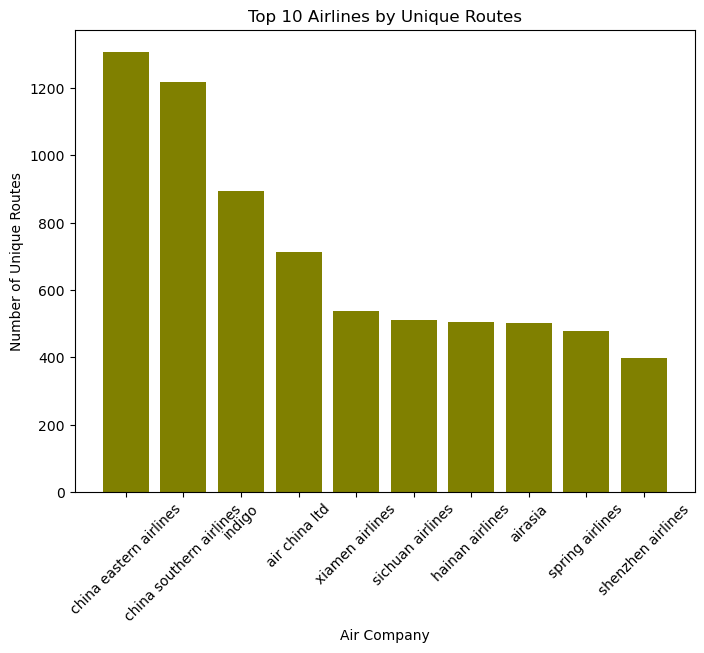

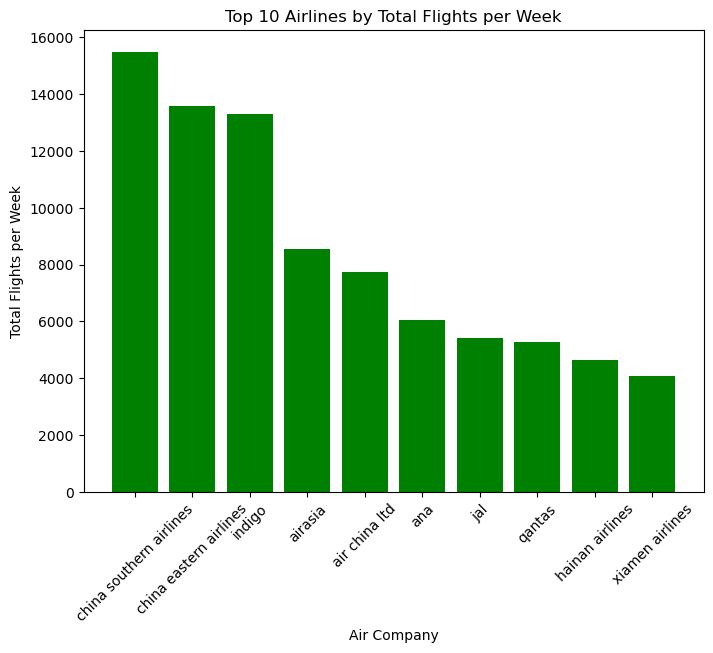

In [206]:
# Group the data by airline and count the number of unique routes for each airline
route_counts = new_df.groupby('airline_name').apply(lambda x: len(x[['departure_iataCode', 'arrival_iataCode']]))
route_counts = route_counts.sort_values(ascending=False)[:10]

# Create a bar chart showing the number of unique routes for each airline
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(route_counts.index, route_counts.values, color=['olive'])
ax.set_title('Top 10 Airlines by Unique Routes')
ax.set_xlabel('Air Company')
ax.set_ylabel('Number of Unique Routes')
plt.xticks(rotation=45)

# Group the data by airline and sum the number of flights for each airline
flight_counts = new_df.groupby('airline_name')['counts'].sum()
flight_counts = flight_counts.sort_values(ascending=False)[:10]

# Create a bar chart showing the total number of flights for each airline
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(flight_counts.index, flight_counts.values, color=['green'])
ax.set_title('Top 10 Airlines by Total Flights per Week')
ax.set_xlabel('Air Company')
ax.set_ylabel('Total Flights per Week')
plt.xticks(rotation=45)

plt.show()

In [207]:
from math import radians, sin, cos, sqrt, atan2
def distance(row):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(row['Latitude_origin'])
    lon1 = radians(row['Longitude_origin'])
    lat2 = radians(row['Latitude_dest'])
    lon2 = radians(row['Longitude_dest'])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance
new_df['distance'] = new_df.apply(distance, axis=1)

In [213]:
# Initialize the graph
L = nx.Graph()

# Add the nodes with their attributes
for i, row in new_df.iterrows():
    origin = row['Airport ID_x']
    destination = row['Airport ID_y']
    origin_lat = row['Latitude_origin']
    origin_long = row['Longitude_origin']
    destination_lat = row['Latitude_dest']
    destination_long = row['Longitude_dest']
    origin_city = row['City_origin']
    destination_city = row['City_dest']
    origin_code = row['departure_iataCode']
    dest_code =row['arrival_iataCode']
    origin_airportname = row['Name_origin']
    dest_airportname = row['Name_dest']
   
    
    L.add_node(origin, lat=origin_lat, lng=origin_long, city=origin_city, code=origin_code, airport = origin_airportname)
    L.add_node(destination, lat=destination_lat, lng=destination_long, city=destination_city, code=dest_code, airport = dest_airportname)

# Add the edges with the attributes
for i, row in new_df.iterrows():
    origin = row['Airport ID_x']
    destination = row['Airport ID_y']
    cnts = row['counts']
    airline_name = row['airline_name']
    kilometers = row['distance']
    
    L.add_edge(origin, destination, weight= kilometers, airline_name =airline_name )

# Save the graph to disk
#nx.write_gml(G, "flights_graph.gml")


nx.write_gexf(L, "graph2023_asiaaustralia.gexf")

In [209]:
# Initialize the graph
F = nx.MultiDiGraph()

# Add the nodes with their attributes
for i, row in new_df.iterrows():
    origin = row['Airport ID_x']
    destination = row['Airport ID_y']
    origin_lat = row['Latitude_origin']
    origin_long = row['Longitude_origin']
    destination_lat = row['Latitude_dest']
    destination_long = row['Longitude_dest']
    origin_city = row['City_origin']
    destination_city = row['City_dest']
    origin_code = row['departure_iataCode']
    dest_code =row['arrival_iataCode']
    origin_airportname = row['Name_origin']
    dest_airportname = row['Name_dest']
   
    F.add_node(origin, lat=origin_lat, lng=origin_long, city=origin_city, code=origin_code, airport=origin_airportname)
    F.add_node(destination, lat=destination_lat, lng=destination_long, city=destination_city, code=dest_code, airport=dest_airportname)

# Add the edges with the attributes
for i, row in new_df.iterrows():
    origin = row['Airport ID_x']
    destination = row['Airport ID_y']
    cnts = row['counts']
    airline_name = row['airline_name']
    kilometers = row['distance']
    
    # Add a new edge with the count and airline name as attributes
    F.add_edge(origin, destination, weight=kilometers, airline_name=airline_name, number_flights = cnts)

# Write the graph to a file
nx.write_gexf(F, "fixed_graph2023_asia.gexf")


#### GRAPH ANALYSIS

In [214]:
print('Number of nodes: {} - Number of links: {}'.format(L.order(),L.size()))

Number of nodes: 1469 - Number of links: 8283


the density of a graph is a measure of how many edges are present in the graph relative to the total number of possible edges. It is calculated as the ratio of the actual number of edges to the total number of possible edges in the graph.

In [153]:
L_density = nx.density(L)
print("Density: " + str(L_density))

Density: 0.007681920452290108


In [154]:
L_degree = list(dict(L.degree()).values())

In [155]:
print("European Air Transportation Graph Degree statistics: ")
print("Mean: " + str(round(np.mean(L_degree),4)))
print("Median: " + str(np.median(L_degree))) 
print("Standard deviation: " + str(round(np.std(L_degree),4)))
print("Maximum: " + str(np.max(L_degree)))
print("Minimum: " + str(np.min(L_degree)))

European Air Transportation Graph Degree statistics: 
Mean: 11.2771
Median: 3.0
Standard deviation: 22.1778
Maximum: 234
Minimum: 1


#### Minimum degree is 1, so there as no isolated nodes. Mean value is higher that median, so we deal with a scale-free network. To verify this we will check degree distribution and compare it to the random network degree distribution

A scale-free network is a type of network where the distribution of node degrees (the number of connections per node) follows a power law.
This means that a few nodes have a very high degree of connections, while most nodes have only a few connections.



## Erdös-Renyi MODEL

In [157]:
p=L_density

In [158]:
rn = nx.fast_gnp_random_graph(L.order(),p)

In [159]:
print('Number of nodes: {} - Number of links: {}'.format(rn.order(),rn.size()))

Number of nodes: 1469 - Number of links: 8205


In [160]:
rn_degree = list(dict(rn.degree()).values())

In [161]:
print("Random Graph Degree statistics (Based on  model): ")
print("Mean: " + str(round(np.mean(rn_degree),4)))
print("Median: " + str(np.median(rn_degree))) 
print("Standard deviation: " + str(round(np.std(rn_degree),4)))
print("Maximum: " + str(np.max(rn_degree)))
print("Minimum: " + str(np.min(rn_degree)))

Random Graph Degree statistics (Based on  model): 
Mean: 11.1709
Median: 11.0
Standard deviation: 3.279
Maximum: 28
Minimum: 2


In [164]:
percentile_99 = np.percentile(L_degree,99)
print(percentile_99)

115.59999999999968


In [165]:
#HUBS 

hub = [k for k,v in dict(L.degree()).items() if v>= percentile_99]
print('Number of hubs:',len(hub))
print('List of hubs:', list(hub))

print('Number of isolated nodes:', list(nx.isolates(L)))

Number of hubs: 15
List of hubs: [3885, 11051, 2188, 3930, 3093, 3393, 3077, 3364, 3406, 3316, 3374, 3370, 3382, 10209, 3379]
Number of isolated nodes: []


In [166]:
df_hubs = dflights_j[dflights_j['Airport ID_x'].isin(hub)]['City_origin'].unique()
print(df_hubs)
                            

['Bangkok' 'Doha' 'Dubai' 'Seoul' 'Delhi' 'Chongqing' 'Hong Kong'
 'Beijing' 'Shanghai' 'Singapore' 'Shenzhen' 'Kunming' "Xi'an"]


In [167]:
print(nx.is_connected(L))
print(nx.number_connected_components(L))

False
2


In [168]:
components = nx.connected_components(L)
for i, component in enumerate(components):
    print(f"Airports in connected component {i+1}:")
    for airport in component:
        print(airport)
    print()

Airports in connected component 1:
1
2
3
4
5
6
8233
8235
8265
8266
146
8340
8341
156
8381
193
8401
210
8407
8417
8428
248
8442
260
273
287
8482
302
309
310
340
342
344
345
346
348
355
421
8630
469
478
492
494
498
502
8695
504
507
521
523
534
535
548
8740
8746
580
582
8781
599
609
629
8826
8831
644
8840
8845
8847
669
671
674
8866
679
680
8876
687
8892
8921
8926
734
737
738
8944
8949
8971
8979
797
799
813
9025
9026
9042
893
894
9090
9091
9095
907
912
915
9107
916
917
918
921
923
930
9127
937
951
9146
979
994
995
999
1016
9225
9229
1074
1075
1107
9308
9310
1121
1128
1130
1132
1138
1145
1165
1173
1175
1177
1180
9373
9378
1186
1187
1190
1194
9386
1196
1197
1208
1218
1229
1252
1335
1353
1354
1380
1382
1386
1489
1501
1509
1524
1525
1528
1538
1551
1555
1561
1562
1569
9770
1582
1587
1590
1612
1613
9805
9821
1638
1646
9843
1652
9845
9846
9848
1657
9849
9853
9854
1663
1665
1678
1682
9874
1685
1688
9886
9887
9888
1699
9891
1701
1706
9898
1726
1739
9935
1745
1824
10061
1959
1960
1961
1963
1965
1015

In [169]:
L_triangles_list = list(nx.triangles(L).values())

In [170]:
# get the number of triangles for each node
triangles = nx.triangles(L)

# print the number of triangles for each node
for node, num_triangles in triangles.items():
    print(f"Node {node} is part of {num_triangles} triangles.")
    
    

Node 5937 is part of 0 triangles.
Node 1128 is part of 55 triangles.
Node 2179 is part of 836 triangles.
Node 2057 is part of 564 triangles.
Node 3885 is part of 1522 triangles.
Node 2997 is part of 967 triangles.
Node 2234 is part of 29 triangles.
Node 3395 is part of 1380 triangles.
Node 2064 is part of 370 triangles.
Node 11051 is part of 1371 triangles.
Node 2188 is part of 1837 triangles.
Node 3386 is part of 1529 triangles.
Node 3930 is part of 1361 triangles.
Node 2176 is part of 808 triangles.
Node 2194 is part of 676 triangles.
Node 2190 is part of 19 triangles.
Node 2191 is part of 632 triangles.
Node 3137 is part of 158 triangles.
Node 3131 is part of 769 triangles.
Node 3136 is part of 273 triangles.
Node 3093 is part of 1276 triangles.
Node 12087 is part of 621 triangles.
Node 3144 is part of 647 triangles.
Node 2195 is part of 63 triangles.
Node 3153 is part of 174 triangles.
Node 3152 is part of 70 triangles.
Node 340 is part of 375 triangles.
Node 2908 is part of 453 tr

In [171]:
transitivity = nx.transitivity(L)
print(transitivity)

0.2631162744852058


transitivity is a measure of the extent to which triangles or triplets in a network are closed. It is defined as the ratio of the number of triangles in a network to the number of connected triples (i.e., the number of triplets that have at least two connected edges). A higher transitivity indicates a higher tendency for nodes to be connected in clusters, which can reflect the presence of cohesive groups or communities within the network.

In [172]:
print('g - average local clustering: {}'.format(nx.average_clustering(L)))

g - average local clustering: 0.4753367055563901


Average local clustering, also known as average clustering coefficient, is a measure of the level of connectivity or clustering among the immediate neighbors of a node in a network. Specifically, it is the average of the local clustering coefficients of all the nodes in the network, where the local clustering coefficient of a node is the ratio of the number of triangles in which the node is a participant to the number of triplets in which the node participates. The average local clustering coefficient is often used as a summary statistic to characterize the overall level of clustering in a network. It is a value between 0 and 1, where a higher value indicates a higher degree of clustering or connectivity among neighboring nodes.

In [173]:
print("Local Clustering Coefficient statistics (L): ")
print('European Network - mean local clustering: {}'.format(np.mean(list(nx.clustering(L).values()))))
print('European Network  - standard deviation local clustering: {}'.format(np.std(list(nx.clustering(L).values()))))
print('European Network  - median local clustering: {}'.format(np.median(list(nx.clustering(L).values()))))
print('European Network  - max local clustering: {}'.format(np.max(list(nx.clustering(L).values()))))
print('European Network  - min local clustering: {}'.format(np.min(list(nx.clustering(L).values()))))

Local Clustering Coefficient statistics (L): 
European Network - mean local clustering: 0.4753367055563901
European Network  - standard deviation local clustering: 0.39343880062229375
European Network  - median local clustering: 0.5
European Network  - max local clustering: 1.0
European Network  - min local clustering: 0.0


In [174]:
local_clustering_L = list(nx.clustering(L).values())

In [176]:
print("Pearson coefficient and p-value between Degree and Clustering coefficient: ")
print(scipy.stats.pearsonr(L_degree, local_clustering_L))

Pearson coefficient and p-value between Degree and Clustering coefficient: 
PearsonRResult(statistic=-0.0834366930911392, pvalue=0.0013705471595110883)


In [177]:
degree_centrality = nx.degree_centrality(L)
eigenvector_centrality = nx.eigenvector_centrality(L)
pr_centrality = nx.pagerank(L)

hub_degree = sorted(degree_centrality.items(),key = lambda x:x[1], reverse=True)[0]
hub_eigenvector = sorted(eigenvector_centrality.items(),key = lambda x:x[1], reverse=True)[0]
hub_pagerank = sorted(pr_centrality.items(),key = lambda x:x[1], reverse=True)[0]

print('degree:      ',hub_degree)
print('eigenvector: ',hub_eigenvector)
print('pagerank: ',hub_eigenvector)

degree:       (2188, 0.15940054495912806)
eigenvector:  (3406, 0.18267018451754177)
pagerank:  (3406, 0.18267018451754177)


In [178]:
print("Pearson coefficient and p-value between Degree and Eigenvector Centralities: ")
print(scipy.stats.pearsonr(list(degree_centrality.values()),list(eigenvector_centrality.values())))
print("Pearson coefficient and p-value between Degree and PageRank Centralities: ")
print(scipy.stats.pearsonr(list(degree_centrality.values()),list(pr_centrality.values())))
print("Pearson coefficient and p-value between Eigenvector and PageRank Centralities: ")
print(scipy.stats.pearsonr(list(eigenvector_centrality.values()),list(pr_centrality.values())))



Pearson coefficient and p-value between Degree and Eigenvector Centralities: 
PearsonRResult(statistic=0.8757908993744488, pvalue=0.0)
Pearson coefficient and p-value between Degree and PageRank Centralities: 
PearsonRResult(statistic=0.8518332705709191, pvalue=0.0)
Pearson coefficient and p-value between Eigenvector and PageRank Centralities: 
PearsonRResult(statistic=0.5718950242882439, pvalue=2.3961920292474414e-128)


In [179]:

print("Spearman and Kendall coefficient between Degree and Eigenvector Centralities: ")
print(scipy.stats.spearmanr(list(degree_centrality.values()),list(eigenvector_centrality.values())))

print("Spearman and Kendall coefficient between Degree and PageRank Centralities: ")
print(scipy.stats.kendalltau(list(degree_centrality.values()),list(pr_centrality.values())))

print("Spearman and Kendall coefficient between Eigenvector and PageRank Centralities: ")
print(scipy.stats.kendalltau(list(eigenvector_centrality.values()),list(pr_centrality.values())))

Spearman and Kendall coefficient between Degree and Eigenvector Centralities: 
SpearmanrResult(correlation=0.7911559190269237, pvalue=1.52446807e-315)
Spearman and Kendall coefficient between Degree and PageRank Centralities: 
KendalltauResult(correlation=0.6703591084424657, pvalue=4.149705100526136e-293)
Spearman and Kendall coefficient between Eigenvector and PageRank Centralities: 
KendalltauResult(correlation=0.36723321586997976, pvalue=1.4189090510689811e-98)


In [180]:
#ASSORTATIVITY - STUDY WHEN CONNECT ADDITIONAL ATTRIBUTES

In [181]:
print("Degree assortativity: " + str(nx.degree_assortativity_coefficient(L)))

Degree assortativity: -0.13637459003633964


In [182]:
#COMMUNITY DETECTION

In [183]:
partition_library = community_louvain.best_partition(L)

In [184]:
print(set(partition_library.values()))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}


In [185]:
nx.set_node_attributes(L, partition_library, "community_library")

In [186]:
comms = set(partition_library.values())

In [187]:
list_community_sets_library = [ set() for i in range(len(comms)) ]

In [188]:
for n, comm in partition_library.items():
    list_community_sets_library[comm].add(n)

In [189]:
#print("Coverage")
print("Coverage", nx_comm.coverage(L, list_community_sets_library))
#print("Modularity")
print("Modularity", nx_comm.modularity(L, list_community_sets_library, weight='weight'))
#print("Performance")
#print("Performance", nx_comm.performance(G, my_list))

Coverage 0.7889653507183387
Modularity 0.6841027912101343


Coverage is a measure of how well a given set of communities covers the nodes in a network. It is defined as the fraction of nodes that are assigned to at least one community. A higher coverage means that the communities are able to capture a larger fraction of the nodes in the network.

Modularity, on the other hand, measures the quality of a given partition of a network into communities. It is defined as the difference between the fraction of edges within communities and the expected fraction of edges within communities if the edges were distributed at random. A higher modularity means that the communities are more tightly connected with each other than expected by chance, indicating a stronger community structure in the network.

In [190]:
pairs = []
for i, nodes in enumerate(list_community_sets_library):
    print(i,len(nodes))
    comm_size = (i,len(nodes))
    pairs.append(comm_size)

0 284
1 126
2 103
3 219
4 5
5 118
6 38
7 3
8 146
9 51
10 11
11 97
12 209
13 8
14 12
15 39


In [191]:
community_index = []
number_of_nodes = []

for comm, n_nodes in pairs:
    community_index.append(str(comm))
    number_of_nodes.append(n_nodes) 

Text(0, 0.5, 'Number of nodes')

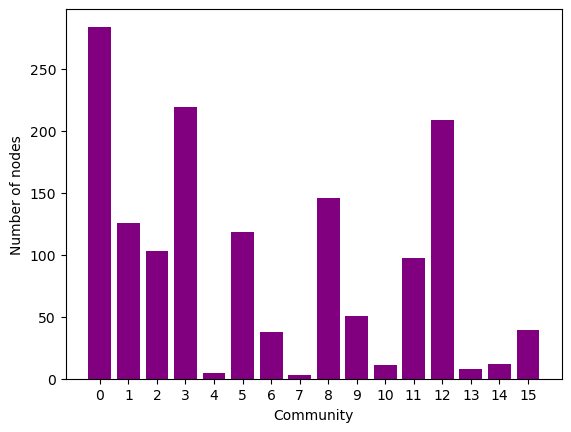

In [192]:
plt.bar(community_index,number_of_nodes, color='purple')
plt.xlabel("Community")
plt.ylabel("Number of nodes")



Centrality in communities


In [193]:
for comm in list_community_sets_library:
    subgraph = L.subgraph(comm)

In [194]:
centr_comm = {}
# node -> centrality in the community subgraph

In [195]:
for comm in list_community_sets_library:
    subgraph = L.subgraph(comm)
    subgraph.order()
    nx.degree_centrality(subgraph)
    
    node_degrees  = nx.degree_centrality(subgraph)
    for n,d in node_degrees.items():
        centr_comm[n] = d

In [196]:
nx.set_node_attributes(L, centr_comm, "centr_comm")

In [197]:
nx.has_bridges(L)

True

In [198]:
nx.write_gexf(L, "L.gexf")